A continuación se presentan los pasos para un análisis exploratorio y de limpieza de Datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import nltk
from nltk.corpus import stopwords
df_edx = pd.read_csv("./Moocs/edx_courses.csv")

1. Observación de las caracteristicas del Data frame (cálculo de nulos y eliminación de duplicados)

In [2]:
df_edx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               975 non-null    object
 1   summary             922 non-null    object
 2   n_enrolled          855 non-null    object
 3   course_type         975 non-null    object
 4   institution         975 non-null    object
 5   instructors         972 non-null    object
 6   Level               975 non-null    object
 7   subject             975 non-null    object
 8   language            975 non-null    object
 9   subtitles           972 non-null    object
 10  course_effort       975 non-null    object
 11  course_length       975 non-null    object
 12  price               975 non-null    object
 13  course_description  935 non-null    object
 14  course_syllabus     417 non-null    object
 15  course_url          975 non-null    object
dtypes: object(16)
memory usage

Text(0.5, 1.0, 'Porcentaje de nulos por columna')

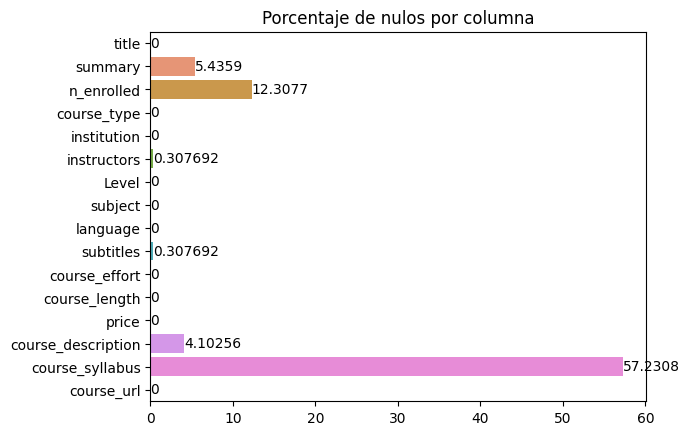

In [3]:
# se observan porcentajes de nulos 
ax = sns.barplot(x = ((df_edx.isnull().sum()*100/df_edx.shape[0])).values, y = df_edx.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de nulos por columna')

In [4]:
# Se normalizan las columnas de tipo texto en minuscula
columns= df_edx.select_dtypes(include="object")
for i in columns:
    df_edx[i] = df_edx[i].str.lower()

2. Limpieza y categorización columna level

<AxesSubplot:xlabel='level', ylabel='count'>

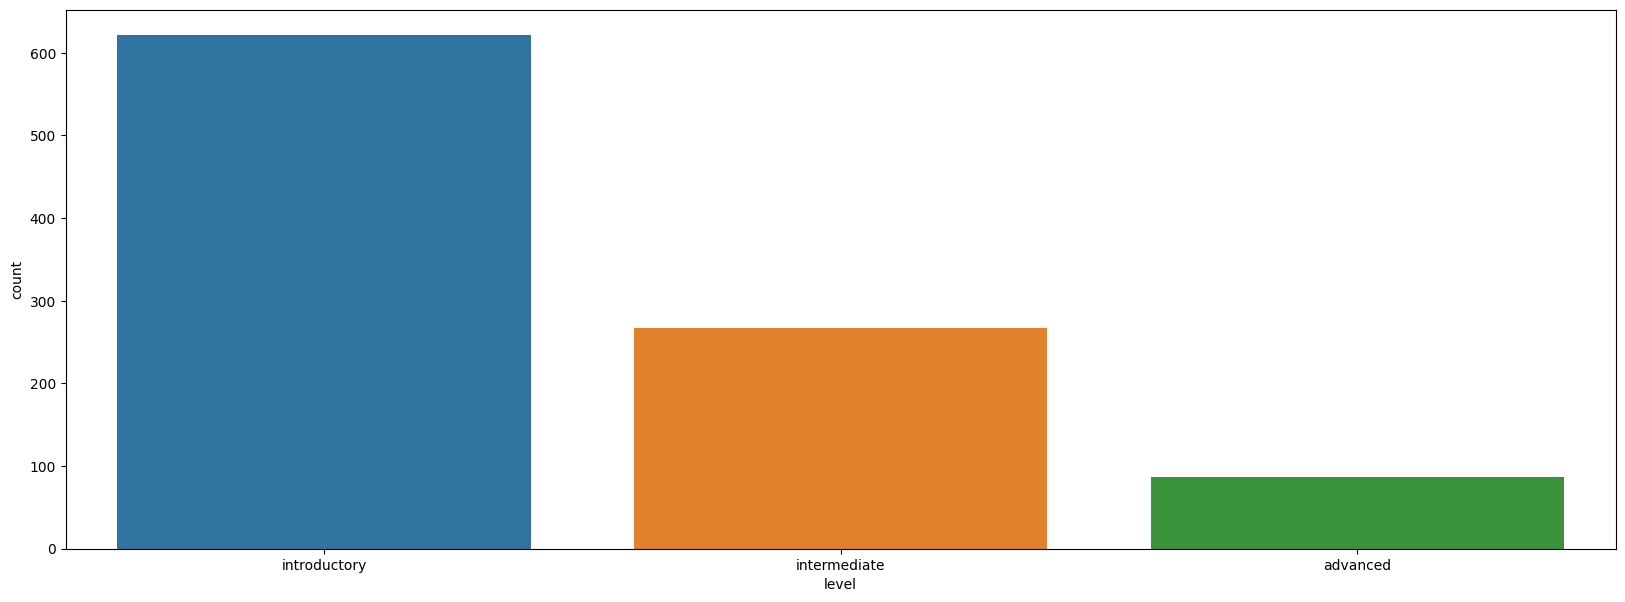

In [5]:
# Se observa la distribución de las categorias level
df_edx.rename(columns = {'Level':'level'}, inplace = True)
plt.figure(figsize=(20,7))
sns.countplot(data=df_edx,x="level")

3. Exploración columna precio

<AxesSubplot:xlabel='price_num', ylabel='count'>

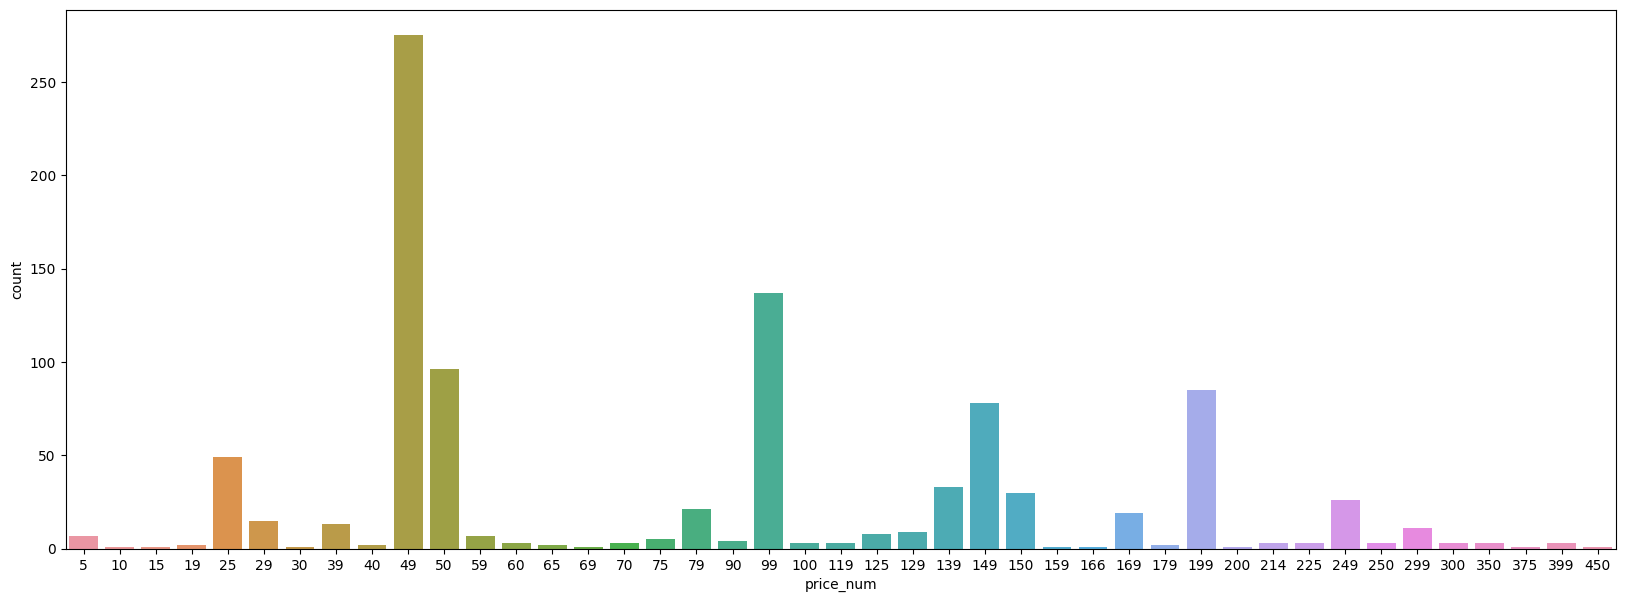

In [6]:
# Se genera una nueva columna con el valor o precio de los certificados por curso
df_edx["price_num"]=df_edx["price"].str.extract("(\d+)")
df_edx["price_num"] = df_edx["price_num"].astype('int')
# se explora la distribucíon de los precios
plt.figure(figsize=(20,7))
sns.countplot(data=df_edx,x="price_num")

In [7]:
# se hace una division en 3 categorias de precio garantizando un numero equitativo de observaciones por cada categoria
df_edx['priceBins'] =  pd.qcut(df_edx['price_num'], 3)
df_edx[['price_num', 'priceBins']].head() 
print(df_edx['priceBins'].value_counts())
#Generar 3 categorias bajo[0-50] medio {50-120} alto[120-450]
df_edx['price_c'] = pd.cut(df_edx['price_num'], bins=[float('-Inf'), 49, 119, float('Inf')], labels=['low', 'medium', 'high'])

(4.999, 49.0]     366
(119.0, 450.0]    324
(49.0, 119.0]     285
Name: priceBins, dtype: int64


4. Se hace la limpeza y generan categorias para la columna idioma

In [8]:
#Crear categorias ingles, español, otro dado que hay idiomas pocos representativos ne la muestra
df_edx.language.value_counts(normalize=True)

english          0.796923
español          0.180513
français         0.007179
italiano         0.004103
中文               0.004103
português        0.004103
日本語              0.001026
اللغة العربية    0.001026
deutsch          0.001026
Name: language, dtype: float64

In [9]:
#Se reducen y agrupan categorias que no tienen mucho peso #en el data set y se agrupan dentro de la categoria otros
# Se crea una serie de la columna lenguaje
language = df_edx.language

# Se hace conteo de idiomas 
language_counts = language.value_counts()

# Print the count values for each category
print(language_counts)

# se crea un filtro para lenguajes con un valor de ocurrencia menor a 10
mask = language.isin(language_counts[language_counts < 10].index)

# generar una categoria nueva llamada otros para agrupar idiomas poco representativos
df_edx.language[mask] = 'other'

#Renombrando idioma
df_edx.language.replace('español','spanish', regex=True, inplace=True)

english          777
español          176
français           7
italiano           4
中文                 4
português          4
日本語                1
اللغة العربية      1
deutsch            1
Name: language, dtype: int64


C:\Users\julia\AppData\Local\Temp\ipykernel_37380\711042885.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edx.language[mask] = 'other'


4. Se crea una nube de palabras para la columna titulo haciendo distinción entre ingles y español

In [10]:
# Limpieza de title 
# Replace all non letter characters with a whitespace
df_edx['title_clean'] = df_edx['title'].str.replace('\d+', ' ', regex=True)

# Replace all non letter characters with a whitespace
def clean_values(series, to_replace, value, regex = True):
    for i in to_replace:
        series = series.str.replace(i, value, regex=regex)
    return series

pattern = [';',',','.',':','!','&','#','-','/','"','@','#','$','%',"'","*","(",")", "|"]
df_edx['title_clean'] = clean_values(df_edx['title_clean'],pattern,value=' ',regex = True)

There are 31991 words in the combination of all review.


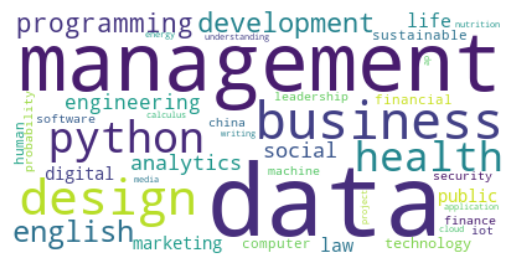

In [11]:
# ver titulos en ingles
mask_eng= df_edx.language == "english"
title_eng = " ".join( i for i in df_edx["title_clean"][mask_eng])
print ("There are {} words in the combination of all review.".format(len(title_eng)))
#Creando word_cloud title ingles
title_eng = " ".join( i for i in df_edx["title_clean"][mask_eng])
stopwords = set(STOPWORDS)
stopwords.update(["basic","s", "learn", "fundamental", "international", "wharton",
                "fundamentals","introduction","intro","uva darden","uva","darden",
                "principles","foundation","foundations","learning",
                "big","everyday","tools","part","analysis","system","science",
                "essential", "essentials","basics","thinking","world","work","systems",
                "method","structure","methods","practice","risk","skills","creating"])
#buscar las filas que tengan wharton
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,max_font_size=80, max_words=40,background_color="white").generate(title_eng)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("./img_edx_eng.jpg")

There are 8148 words in the combination of all review.


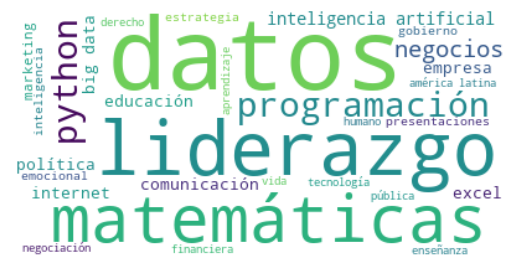

In [13]:
from nltk.corpus import stopwords
#Creando word cloud español
mask_esp = df_edx.language == "spanish"
#Creando word_cloud title spanish
title_esp = " ".join( i for i in df_edx["title_clean"][mask_esp])
print ("There are {} words in the combination of all review.".format(len(title_esp)))
stopwords_esp = set(stopwords.words('spanish'))
stopwords_esp.update(["introducción", "cómo", "herramienta","fundamentos","herramientas","básico",
                    "conceptos","desarrollo","estructura","básicos","aprende","principio","principios",
                    "base","bases","diseño","análisis","efectiva","digital","ciencia","gestión","información",
                    "ingeniería","proyectos","estructuras"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords_esp,max_font_size=80, max_words=30,background_color="white").generate(title_esp)
#wordcloud = WordCloud(max_font_size=80, max_words=10,background_color="white").generate(title_esp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("./img_edx_esp.png")

There are 858 words in the combination of all review.


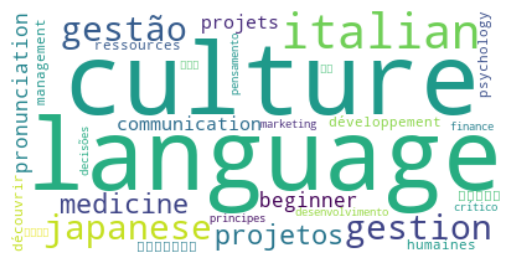

In [14]:
#Creando word_cloud title otros idiomas 
mask_other = df_edx.language == "other"
#Creando word_cloud title spanish
title_other = " ".join( i for i in df_edx["title_clean"][mask_other])
print ("There are {} words in the combination of all review.".format(len(title_other)))
stopwords_other = set(STOPWORDS)
stopwords_other.update(["basic", "learn", "fundamental", "international", "fundamentals",
                "introduction","intro","principles","foundation","foundations",
                "learning","big","everyday","tools", "to","fondements","le","ap","la","em","les",
                "riscos","intermediate","advanced","tomada","de","des","fundamentadas"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords_other,max_font_size=80, max_words=30,background_color="white").generate(title_other)
#wordcloud = WordCloud(max_font_size=80, max_words=10,background_color="white").generate(title_esp)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<AxesSubplot:xlabel='language', ylabel='Count'>

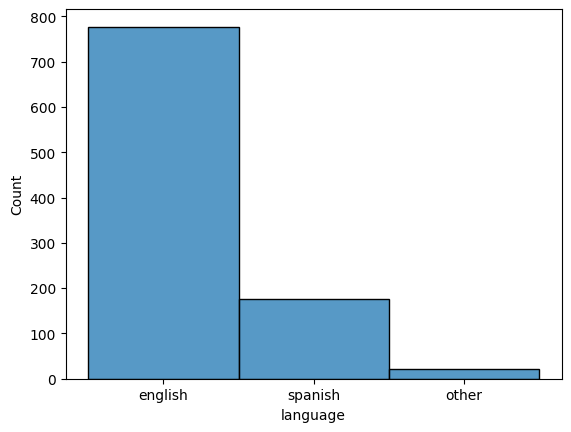

In [ ]:
sns.histplot(df_edx.language)

5. Se hace limpieza en la columna n_enrolled. Se observan presencia de outliers y nulos

In [ ]:
#Pra los outliers se decide asignarles un valor igual a la cota 
#superior (75%) para el numero de personas registradas según subject - tematica
df_edx.n_enrolled = df_edx.n_enrolled.astype("float")
df_edx["n_enrolled"].describe()
df_edx.groupby("subject")["n_enrolled"].describe()
upper_bound = df_edx.groupby("subject")["n_enrolled"].describe()
upper_bound = round(upper_bound["75%"],0)
subject_max_dict = upper_bound.to_dict()
#Mapear outliers

print(upper_bound.shape)
mask_edx = df_edx["n_enrolled"] > df_edx["subject"].map(subject_max_dict)

#reemplazo de outliers
df_edx["n_enrolled"] = np.where(df_edx["n_enrolled"] > df_edx["subject"].map(subject_max_dict),df_edx["subject"].map(subject_max_dict),df_edx["n_enrolled"])

# se verifican la reducción de outliers en al dataframe
plt.figure(figsize=(50,7))
sns.boxplot(df_edx, x=df_edx["subject"], y= df_edx["n_enrolled"])

In [ ]:
#Imputar nulos con el promedio por subject
mask_null = df_edx["n_enrolled"].isnull()
# Map the dictionary to missing values of column by columngroupby
df_edx["n_enrolled"] = df_edx["n_enrolled"].fillna(df_edx["subject"].map(subject_max_dict))
df_edx["n_enrolled"].isnull()
#Eliminar nulos category philantropy
df_edx.dropna(subset = ['n_enrolled'], inplace=True)

6. Se genera una nueva columna Ventas

In [ ]:
#Crear columna ventas
df_edx.n_enrolled = df_edx.n_enrolled.astype("float")
df_edx.price_num = df_edx.price_num.astype("float")
df_edx["ventas"] = df_edx["n_enrolled"]*df_edx["price_num"]

7. Se eliminan las columnas que no seran consideradas en análisis próximos

In [ ]:
df_edx.drop(columns=["title","summary","course_type","instructors",
            "subtitles","course_effort","course_length","course_description","course_syllabus","course_url"], axis=1, inplace=True)


8. Se exporta el dataframe a un archivo csv corrigiendo algunos nombres de columnas

In [ ]:
df_edx.rename(columns= {"price_num":"price_usd","title_clean":"title"}, inplace = True)
df_edx.to_csv("edx.csv")